In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Convolution

#### 1D Convolution

In [2]:
# Convolves a 1D array with a kernel
def conv1D(inSignal:np.ndarray,kernel1:np.ndarray)->np.ndarray:
    if(kernel1.shape[0] % 2 == 0):
        pad_size = int((kernel1.shape[0])/2)
        padded_signal = np.pad(inSignal, pad_size, 'constant', constant_values=0)
        new_signal = np.array([])
        # Apply kernel to each pixel
        for i in range(0, padded_signal.shape[0]-pad_size-1):
            sub_signal = padded_signal[i:i+pad_size+1]
            prod = sub_signal*kernel1
            sub_signal_sum = np.sum(prod)
            new_signal = np.append(new_signal, sub_signal_sum)
    else:
        # Padding array with zeros so resulting array is same length as original
        pad_size = int((kernel1.shape[0]-1)/2)
        padded_signal = np.pad(inSignal, pad_size, 'constant', constant_values=0)
        new_signal = np.array([])
        # Apply kernel to each pixel
        for i in range(pad_size, padded_signal.shape[0]-pad_size):
            sub_signal = padded_signal[i-pad_size:i+pad_size+1]
            prod = sub_signal*kernel1
            sub_signal_sum = np.sum(prod)
            new_signal = np.append(new_signal, sub_signal_sum)
    return new_signal

In [3]:
conv1D(np.array([1,1]),np.array([1,1]))

array([1., 2.])

In [4]:
np.convolve(np.array([1,1]),np.array([1,1]),'same')

array([1, 2])

#### 2D Convolution

In [127]:
def conv2D(inImage:np.ndarray,kernel2:np.ndarray)->np.ndarray:
#     inImage = cv2.cvtColor(inImage, cv2.COLOR_BGR2GRAY)
    pad_size = int((kernel2.shape[0]-1)/2)
#     padded_image = np.pad(inImage, ((pad_size,pad_size),(pad_size,pad_size)), 'constant', constant_values=0)
    padded_image = np.pad(inImage, ((pad_size,pad_size),(pad_size,pad_size)), 'reflect')
    new_image = np.zeros(padded_image.shape)
    for i in range(pad_size, padded_image.shape[0]-pad_size):
        for j in range(pad_size, padded_image.shape[1]-pad_size):
            sub_image = padded_image[i-pad_size:i+pad_size+1,j-pad_size:j+pad_size+1]
            prod = sub_image*kernel2
            sub_image_sum = np.sum(prod)
            new_image[i,j] = sub_image_sum
    return new_image[pad_size:-pad_size,pad_size:-pad_size]

In [6]:
def mean_ker(size):
    return np.full((size,size),1)/(size*size)

(400, 400)

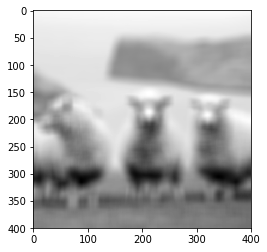

In [7]:
img = cv2.imread("sheep.png")
ker = np.full((19,19),1)
ker = ker/np.sum(ker)
res = conv2D(img,ker)
plt.imshow(res,'gray')
res.shape

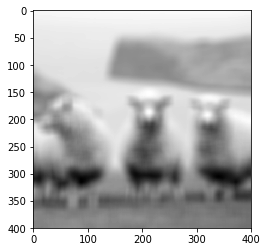

In [8]:
# res2 = cv2.filter2D(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),-1,ker,borderType=0)
res2 = cv2.filter2D(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),-1,ker)
plt.imshow(res2,'gray')

0.49861495844879755

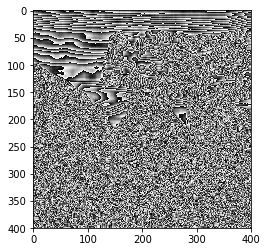

In [9]:
plt.imshow(res2-res,'gray')
np.max(res2-res) # max pixel value diff between my result and opencv's

# Image derivatives & blurring

#### Derivatives

In [10]:
def convDerivative(inImage:np.ndarray) -> np.ndarray:
    inImage = cv2.cvtColor(inImage, cv2.COLOR_BGR2GRAY)
    ker = np.array([1,0,-1])
    h,w = inImage.shape[:2]
    der_x = np.zeros((h,w))
    for i in range(h):
        der_x[i] = conv1D(inImage[i], ker)
    der_y = np.zeros((h,w))
    img_trans = np.transpose(inImage)
    for i in range(w):
        der_y[i] = conv1D(img_trans[i], np.transpose(ker))
    der_y = np.transpose(der_y)
    mag = np.sqrt(der_x**2 + der_y**2)
    return mag

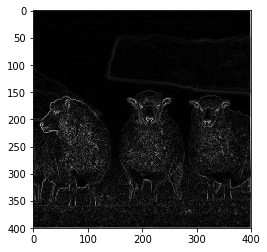

In [11]:
plt.imshow(convDerivative(img),'gray')

#### Blurring

0.9999999999999999

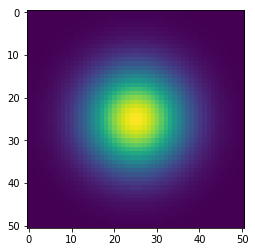

In [235]:
def gauss_row(size):
    arr = np.array([1,1])
    ker = np.array([1,1])
    for i in range(size-2):
        arr = np.convolve(arr,ker)
    return arr/np.sum(arr)

def G(x,y,sigma):
    return (1/2*np.pi*sigma*sigma)*np.e**(-(x**2+y**2)/2*sigma**2)

def gauss(size):
    sigma = 1/(0.3*((size-1)*0.5 - 1) + 0.8)
    mat = np.zeros((size,size))
    center = np.ceil(size/2)-1
    for i in range(size):
        for j in range(size):
            mat[i,j] = G(np.abs(i-center),np.abs(j-center),sigma)
    return mat/np.sum(mat)

plt.imshow(gauss(51))
np.sum(gauss(51))

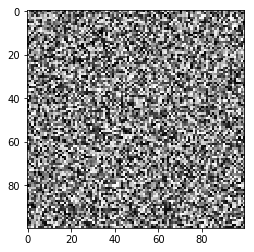

In [258]:
import random
mat = np.zeros((100,100))
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        mat[i,j] = random.randint(0,255)
plt.imshow(mat,'gray')

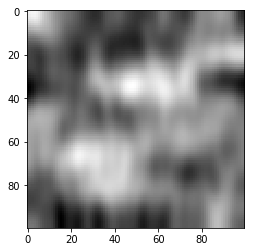

In [267]:
mat2 = conv2D(mat,cv2.getGaussianKernel(35,-1))
mat2 = np.transpose(conv2D(np.transpose(mat2),cv2.getGaussianKernel(9,-1)))
plt.imshow(mat2,'gray')

In [229]:
def blurImage1(inImage:np.ndarray,kernelSize:np.ndarray)->np.ndarray:
    new_image = np.zeros(inImage.shape)
    channels = 1
    if len(inImage.shape) == 3:
        channels = inImage.shape[2]
    ker = []
    for i in range(kernelSize.shape[0]):
        ker.append(gauss(kernelSize[i]))
    ker = np.array(ker)
    if(channels > 1):
        for i in range(inImage.shape[2]):
            new_image[:,:,i] = conv2D(new_image[:,:,i],ker[i])
    else:
         new_image = conv2D(inImage,ker[0])
    return new_image

def blurImage2(inImage:np.ndarray,kernelSize:np.ndarray)->np.ndarray:
    channels = 1
    if len(inImage.shape) == 3:
        channels = inImage.shape[2]
    ker = []
    for i in range(kernelSize.shape[0]):
        ker.append(cv2.getGaussianKernel(kernelSize[i],-1))
    ker = np.array(ker)
    if(channels > 1):
        for i in range(inImage.shape[2]):
            inImage[:,:,i] = cv2.filter2D(inImage[:,:,i],-1,ker[i])
        inImage = np.transpose(inImage)
        for i in range(inImage.shape[2]):
            inImage[:,:,i] = cv2.filter2D(inImage[:,:,i],-1,ker[i])
    else:
        inImage = cv2.filter2D(inImage,-1,ker[0])
        inImage = np.transpose(inImage)
        inImage = cv2.filter2D(inImage,-1,ker[0])
    return np.transpose(inImage)

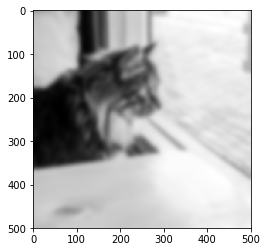

In [232]:
img = cv2.imread("cat.jpg",0)
res2 = blurImage1(img,np.array([31]))
plt.imshow(res2,'gray')

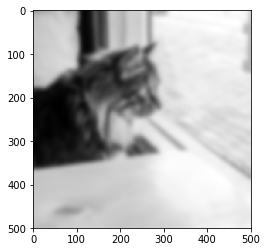

In [233]:
img = cv2.imread("cat.jpg",0)
res2 = blurImage2(img,np.array([31]))
plt.imshow(res2,'gray')

0

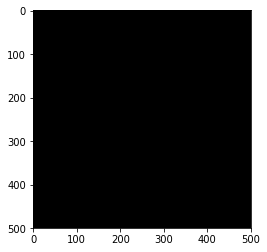

In [234]:
plt.imshow(res2-res1,'gray')
np.max(res2-res1)

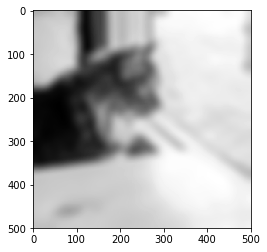

In [75]:
res2 = cv2.GaussianBlur(img,(35,35),10)
res2 = cv2.cvtColor(res2, cv2.COLOR_BGR2GRAY)
plt.imshow(res2, 'gray')

In [ ]:
kernel2 = np.full((51,51),1)
# kernel2 = gaussian_kernel(31)
inImage = np.full((100,100),1)
pad_size = int((kernel2.shape[0]-1)/2)
padded_image = np.pad(inImage, ((pad_size,pad_size),(pad_size,pad_size)), 'constant', constant_values=0)
new_image = np.zeros(inImage.shape)
for i in range(pad_size, padded_image.shape[0]-pad_size):
    for j in range(pad_size, padded_image.shape[1]-pad_size):
        sub_image = padded_image[i-pad_size:i+pad_size+1,j-pad_size:j+pad_size+1]
        if sub_image.shape != kernel2.shape :
            print(sub_image.shape,i-pad_size,i+pad_size+1,j-pad_size,j+pad_size+1)
        prod = sub_image*kernel2
        sub_image_sum = np.sum(prod)
        new_image[i-pad_size,j-pad_size] = sub_image_sum
# print(i-pad_size,j-pad_size)

In [ ]:
new_image

In [ ]:
plt.imshow(new_image, 'gray')